In [1]:
import torch
import os
import sys
sys.path.insert(0, os.path.abspath('../../'))
from DNN_module import Net

# CPU
torch.set_default_device("cpu")

%run ../../NCoinDP_functions.ipynb

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import random
import torch

# Number of data points
#S = 500

# time inteval

delta = 1/12

#n = int(S/delta)
n = 5000

# Observation time
obtime = np.arange(0,n+1)/n * n * delta
print(len(obtime))

5001


In [3]:
print(torch.__version__)
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))
if torch.cuda.is_available(): 
 dev = "cuda:0" 
else: 
 dev = "cpu"
device = torch.device(dev)

2.1.2+cu121
True
NVIDIA A10


In [17]:
#L = 1500000

beta_range = [-0.5, 0.5]
sigma2_range = [0.1, 1]

lamb_p_range = [0.1, 1]
lamb_n_range = [0.1, 1]

eta_p_range = [0.1, 1]
eta_n_range = [0.1, 1]
output_range = np.array([beta_range, sigma2_range, lamb_p_range, lamb_n_range, eta_p_range, eta_n_range])


In [5]:
# Data import
torch.set_default_device(device)

X_raw = []
output_raw = []
for j in [0, 1]:
    sim_path = "../../../depot_hyun/hyun/PBJD/PBJD_sim" + str(j) + "_" + str(n)+ ".pt"
    [tmp_X, tmp_y] = torch.load(sim_path)
    X_raw.append(tmp_X)
    output_raw.append(tmp_y)

X_raw = torch.cat(X_raw, dim = 0)
output = torch.cat(output_raw, dim = 0)
X_raw = X_raw.to("cpu")

c_tmp = torch.quantile(X_raw, torch.tensor([.0001,.9999], device = "cpu"), 0)
a = torch.reshape(c_tmp[0], (1, c_tmp.size()[1]))
b = torch.reshape(c_tmp[1], (1, c_tmp.size()[1]))

X = torch.clone((X_raw - a) / (b - a))

X = X.to(device)
output = output.to(device)

L = X.size()[0]
Lval = 40000
Ltest = 10000

X_train = X[range(0,L-Lval-Ltest),:]
y_train = output[range(0,L-Lval-Ltest),:]

X_val = X[range(L-Lval-Ltest,L-Ltest),:]
y_val = output[range(L-Lval-Ltest,L-Ltest),:]

X_test = X[range(L-Ltest,L),:]
y_test = output[range(L-Ltest,L),:]

print(X_train.size(), X_val.size(),X_test.size())

# Define the input and output dimensions
D_in, H, H2, H3, D_out = X_train.size()[1], 512, 512, 512, y_train.size()[1]

# Create an instance of the Net class with specified dimensions
torch.manual_seed(2725)

# import net
net = Net(D_in, D_out, H = H, H2 = H2, H3 = H3)
model_save_name = 'PBJD_nets/PBJD_infer.pt'
path = F"./{model_save_name}"

torch.Size([450000, 90]) torch.Size([40000, 90]) torch.Size([10000, 90])


In [6]:
for i in range(X.size()[1]):
    print(i, torch.max(X[:,i]), a[0,i], b[0,i])

0 tensor(1.1288, device='cuda:0') tensor(-9.7704) tensor(9.5731)
1 tensor(1.2599, device='cuda:0') tensor(2.2307e-05) tensor(0.0003)
2 tensor(1.0476, device='cuda:0') tensor(1.3988e-05) tensor(0.0427)
3 tensor(1.0020, device='cuda:0') tensor(-0.1232) tensor(40.0643)
4 tensor(1.0023, device='cuda:0') tensor(1.3625e-08) tensor(8.0009)
5 tensor(1.0502, device='cuda:0') tensor(0.0002) tensor(0.5106)
6 tensor(1.0579, device='cuda:0') tensor(0.3101) tensor(0.6557)
7 tensor(1.0578, device='cuda:0') tensor(0.3099) tensor(0.6557)
8 tensor(1.0578, device='cuda:0') tensor(0.3097) tensor(0.6555)
9 tensor(1.0579, device='cuda:0') tensor(0.3091) tensor(0.6547)
10 tensor(1.0591, device='cuda:0') tensor(0.3083) tensor(0.6535)
11 tensor(1.0585, device='cuda:0') tensor(0.3073) tensor(0.6525)
12 tensor(1.0639, device='cuda:0') tensor(0.3005) tensor(0.6449)
13 tensor(1.0565, device='cuda:0') tensor(0.2909) tensor(0.6343)
14 tensor(1.0536, device='cuda:0') tensor(0.2811) tensor(0.6247)
15 tensor(1.0495, de

In [7]:
import torch
import torch.optim as optim
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset
# N is batch size; 
# D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
# L = 1000 -> H = 64

# Define the batch size
BATCH_SIZE = 64


# Use torch.utils.data to create a DataLoader 
# that will take care of creating batches 
dataset = TensorDataset(X_train, y_train)
dataloader = DataLoader(dataset, batch_size = BATCH_SIZE, shuffle=True, generator=torch.Generator(device=device))
dataset_size = len(dataloader.dataset)

In [8]:
def weighted_mse_loss(input, target, weight):
        return (weight * (input - target) ** 2).sum()
out_range = [torch.quantile(output,.01, 0).detach().cpu().numpy(), torch.quantile(output,.99, 0).detach().cpu().numpy()]
weight_1 = torch.tensor(1/(out_range[1] - out_range[0])**2)
print(weight_1)

tensor([1.0417, 1.2861, 1.2849, 1.2855, 1.2838, 1.2853], device='cuda:0')


In [ ]:
learning_rate = 1e-4
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, weight_decay=1e-5)

train_error_plt = []
val_error_plt = []

torch.manual_seed(2000)
N_EPOCHS = 350
# Loop over epochs
for epoch in range(N_EPOCHS):
    for id_batch, (x_batch, y_batch) in enumerate(dataloader):
        y_batch_pred = net(x_batch)
        #loss = loss_fn(y_batch_pred, y_batch)
        loss = weighted_mse_loss(y_batch, y_batch_pred, weight_1)


        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if epoch % 10 ==0 and id_batch % 1000 == 0:
            loss, current = loss.item(), (id_batch + 1)* len(x_batch)
            print(f"train_loss: {loss/BATCH_SIZE:>7f}  [{current:>5d}/{dataset_size:>5d}]")

    with torch.no_grad():
           net.eval()
           theta_pred_train = net(X_train)
           #train_loss = loss_fn(theta_pred_train,Y_train) / L_train
           train_loss = weighted_mse_loss(y_train, theta_pred_train, weight_1) /( L - Lval - Ltest )
           
           train_error_plt = np.append(train_error_plt, train_loss.to("cpu"))

           theta_pred_val = net(X_val)
           #val_loss = loss_fn(Y_val, theta_pred_val) / L_val
           val_loss = weighted_mse_loss(y_val, theta_pred_val, weight_1) / Lval
           
           val_error_plt = np.append(val_error_plt, val_loss.to("cpu"))

    if epoch % 10 ==0:
        print(f"Epoch {epoch + 1}\n-------------------------------")
        print(f"train_loss {train_loss:>7f} val_loss {val_loss:>7f}")
        #print("learning rate: ", learning_rate, ", sim: ", sim)

    ## Choose Best Model
    if val_error_plt[epoch] == np.min(val_error_plt):
         best=epoch
         torch.save(net.state_dict(), path)

    if epoch % 100 ==99:
        net.load_state_dict(torch.load(path))
        learning_rate = max(learning_rate * 1e-1, 1e-9)

train_loss: 2.694545  [   64/450000]
train_loss: 0.042498  [64064/450000]
train_loss: 0.043177  [128064/450000]
train_loss: 0.040547  [192064/450000]
train_loss: 0.034890  [256064/450000]
train_loss: 0.040787  [320064/450000]
train_loss: 0.031491  [384064/450000]
train_loss: 0.024115  [448064/450000]
Epoch 1
-------------------------------
train_loss 0.024796 val_loss 0.024859
train_loss: 0.015936  [   64/450000]
train_loss: 0.013955  [64064/450000]
train_loss: 0.018030  [128064/450000]
train_loss: 0.015666  [192064/450000]
train_loss: 0.017690  [256064/450000]
train_loss: 0.017102  [320064/450000]
train_loss: 0.013880  [384064/450000]
train_loss: 0.015127  [448064/450000]
Epoch 11
-------------------------------
train_loss 0.016384 val_loss 0.016548
train_loss: 0.014281  [   64/450000]
train_loss: 0.017682  [64064/450000]
train_loss: 0.016580  [128064/450000]
train_loss: 0.015585  [192064/450000]
train_loss: 0.016847  [256064/450000]
train_loss: 0.015038  [320064/450000]
train_loss: 0

train_loss: 0.013958  [320064/450000]
train_loss: 0.015464  [384064/450000]
train_loss: 0.014919  [448064/450000]
Epoch 211
-------------------------------
train_loss 0.015625 val_loss 0.016212
train_loss: 0.013602  [   64/450000]
train_loss: 0.013591  [64064/450000]
train_loss: 0.017656  [128064/450000]
train_loss: 0.016066  [192064/450000]
train_loss: 0.018090  [256064/450000]
train_loss: 0.015061  [320064/450000]
train_loss: 0.012882  [384064/450000]
train_loss: 0.017508  [448064/450000]
Epoch 221
-------------------------------
train_loss 0.015603 val_loss 0.016237
train_loss: 0.013017  [   64/450000]
train_loss: 0.012662  [64064/450000]
train_loss: 0.017447  [128064/450000]
train_loss: 0.019363  [192064/450000]
train_loss: 0.015507  [256064/450000]
train_loss: 0.013373  [320064/450000]
train_loss: 0.015833  [384064/450000]
train_loss: 0.015038  [448064/450000]
Epoch 231
-------------------------------
train_loss 0.015437 val_loss 0.016062
train_loss: 0.017323  [   64/450000]
train

In [ ]:
print(np.min(val_error_plt))

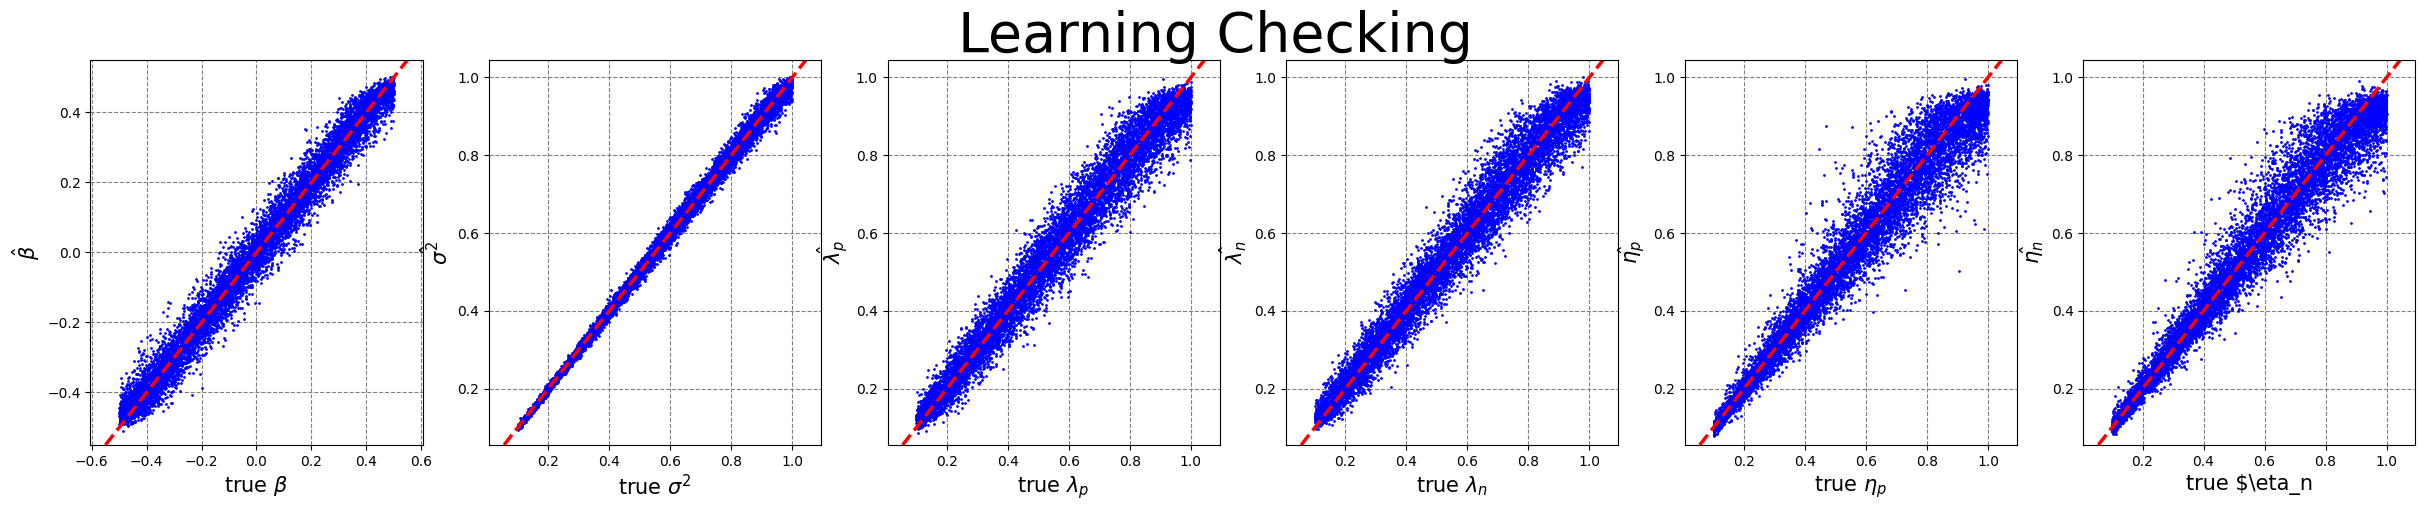

In [9]:
net.load_state_dict(torch.load(path))
net.eval()
torch.set_default_device("cpu")

net = net.to("cpu")
X_test = X_test.to("cpu")
y_test = y_test.to("cpu")


true_name = [r'true $\beta$', r'true $\sigma^2$', r'true $\lambda_p$', r'true $\lambda_n$', r'true $\eta_p$', r'true $\eta_n']
esti_name = [r'$\hat{\beta}$', r'$\hat{\sigma^2}$', r'$\hat{\lambda_p}$', r'$\hat{\lambda_n}$', r'$\hat{\eta_p}$', r'$\hat{\eta_n}$']


with torch.no_grad():
    net.eval()
    tmp = net(X_test)

## Plot for model checking
lim = [torch.min(output,0).values.detach().cpu().numpy(), torch.max(output,0).values.detach().cpu().numpy()]
lim = np.array(list(lim))
lim2 = lim[1] - lim[0]
lim = [lim[0] - lim2 * 1/20, lim[1] + lim2 * 1/20 ]
lim = np.array(lim)
fig, axes = plt.subplots(1, D_out, figsize=(5 * D_out,5))
fig.suptitle('Learning Checking', fontsize = 40)

for i in range(D_out):
    lim1 = lim[:,i]
    tmp1 = tmp[:,i].detach().cpu().numpy().tolist() 
    axes[i].scatter(y_test[:,i], tmp1, marker='o', color='b', s= 1)
    axes[i].set_xlabel(true_name[i], fontsize=15)
    axes[i].set_ylabel(esti_name[i], fontsize=15)
    axes[i].plot(np.linspace(lim1[0], lim1[1], 1000), np.linspace(lim1[0], lim1[1], 1000), color = "red", linestyle='dashed', linewidth = 2.5)
    axes[i].set_axisbelow(True)
    axes[i].grid(color='gray', linestyle='dashed')
    axes[i].set_ylim(lim1)

In [10]:
torch.set_default_device("cpu")
torch.manual_seed(2726)

sim_test = 1
y0 = 0 * torch.ones(sim_test)

param = torch.tensor([0, 0.75, 0.15, 0.20, 0.8, 0.75]) 
param1 = torch.tensor([0.3, 0.45, 0.45, 0.55, 0.5, 0.45]) 
param2 = torch.tensor([-0.3, 0.15, 0.80, 0.70, 0.2, 0.25]) 


torch.manual_seed(2)
    
yL = PBJD_simul_sample(obtime, y0, param[0]*torch.ones(sim_test), param[1] ** (1/2)*torch.ones(sim_test), 
        param[2]* torch.ones(sim_test), param[3]* torch.ones(sim_test), param[4]* torch.ones(sim_test), 
                           param[5] * torch.ones(sim_test))
    
x_test = PBJD_summary(yL, delta)

yL1 = PBJD_simul_sample(obtime, y0, param1[0]*torch.ones(sim_test), param1[1] ** (1/2)*torch.ones(sim_test), 
    param1[2]* torch.ones(sim_test), param1[3]* torch.ones(sim_test), param1[4]* torch.ones(sim_test), 
                            param1[5] * torch.ones(sim_test))

x_test1 = PBJD_summary(yL1, delta)

yL2 = PBJD_simul_sample(obtime, y0, param2[0]*torch.ones(sim_test), param2[1] ** (1/2)*torch.ones(sim_test), 
    param2[2]* torch.ones(sim_test), param2[3]* torch.ones(sim_test), param2[4]* torch.ones(sim_test), 
                            param2[5] * torch.ones(sim_test))

x_test2 = PBJD_summary(yL2, delta)


print(x_test.size())

torch.Size([1, 90])


In [11]:
x_test_scale = torch.clone((x_test - a ) / (b - a))
x_test1_scale = torch.clone((x_test1 - a ) / (b - a))
x_test2_scale = torch.clone((x_test2 - a ) / (b - a))

In [12]:
print(torch.mean(net(x_test_scale),0))
print(torch.mean(net(x_test1_scale),0))
print(torch.mean(net(x_test2_scale),0))


tensor([0.0090, 0.7337, 0.2431, 0.2062, 0.8511, 0.8244],
       grad_fn=<MeanBackward1>)
tensor([0.2861, 0.4650, 0.4247, 0.4909, 0.5568, 0.3993],
       grad_fn=<MeanBackward1>)
tensor([-0.2856,  0.1565,  0.7459,  0.5726,  0.2103,  0.2701],
       grad_fn=<MeanBackward1>)


In [13]:
x0 = torch.reshape(x_test_scale, (1,x_test_scale.size()[1]))
x1 = torch.reshape(x_test1_scale, (1,x_test_scale.size()[1]))
x2 = torch.reshape(x_test2_scale, (1,x_test_scale.size()[1]))

In [14]:
net.load_state_dict(torch.load(path))
net = net.to("cpu")
net.eval()

Net(
  (fc1): Linear(in_features=90, out_features=512, bias=True)
  (bn1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dn1): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (bn2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dn2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=512, out_features=512, bias=True)
  (bn3): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dn3): Dropout(p=0.2, inplace=False)
  (fc4): Linear(in_features=512, out_features=6, bias=True)
)

In [15]:
path_cal = "../../../depot_hyun/hyun/PBJD/PBJD_sim"
    
X_cal = []
y_cal = []

sim_num = []
for j in range(2, 30):
    sim_num.append(j)

for j in sim_num:
    path_tmp = path_cal+str(j)+ "_" + str(n)+ ".pt"
    [tmp_X, tmp_y] = torch.load(path_tmp)
    X_cal.append(tmp_X)
    y_cal.append(tmp_y)

X_cal = torch.cat(X_cal, dim = 0)
y_cal = torch.cat(y_cal, dim = 0)

X_cal = torch.clone((X_cal - a) / (b - a))

In [ ]:
results_00 = conf_inf_sd(x0, X_cal, y_cal, net, .03)
results_01 = conf_inf_sd(x0, X_cal, y_cal, net, .04)
results_02 = conf_inf_sd(x0, X_cal, y_cal, net, .05)
torch.save([results_00, results_01, results_02], "PBJD_calibrate/PBJD_infer_0.pt")

In [ ]:
net.eval()

results_10 = conf_inf_sd(x1, X_cal, y_cal, net, .03)
results_11 = conf_inf_sd(x1, X_cal, y_cal, net, .04)
results_12 = conf_inf_sd(x1, X_cal, y_cal, net, .05)
torch.save([results_10, results_11, results_12], "PBJD_calibrate/PBJD_infer_1.pt")

In [ ]:
net.eval()

results_20 = conf_inf_sd(x2, X_cal, y_cal, net, .03)
results_21 = conf_inf_sd(x2, X_cal, y_cal, net, .04)
results_22 = conf_inf_sd(x2, X_cal, y_cal, net, .05)
torch.save([results_20, results_21, results_22], "PBJD_calibrate/PBJD_infer_2.pt")

In [18]:
# Sampling
size = 30000

samples = []
for case in range(3):
    sam_0 = [] 
    tmp = torch.load("PBJD_calibrate/PBJD_infer_" +str(case) + ".pt")

    for r in range(3):
        sam_1 = [] # size 6 * size
        results = tmp[r]
        for j in range(results[1].size()[1]):
            random.seed(10)
            vec = results[1][:,j].detach().cpu().numpy()
            ind = ((vec<output_range[j][1]) & (vec>output_range[j][0]))
            vec = np.copy(vec[ind])
            
            weights = np.copy(results[0].detach().cpu().numpy())
            weights = np.copy(weights[ind])
            P = weights/weights.sum()

            sam_2 = np.random.choice(vec,size,replace=True, p=P)
            sam_1.append(sam_2) 
        sam_0.append(sam_1)
    samples.append(sam_0)

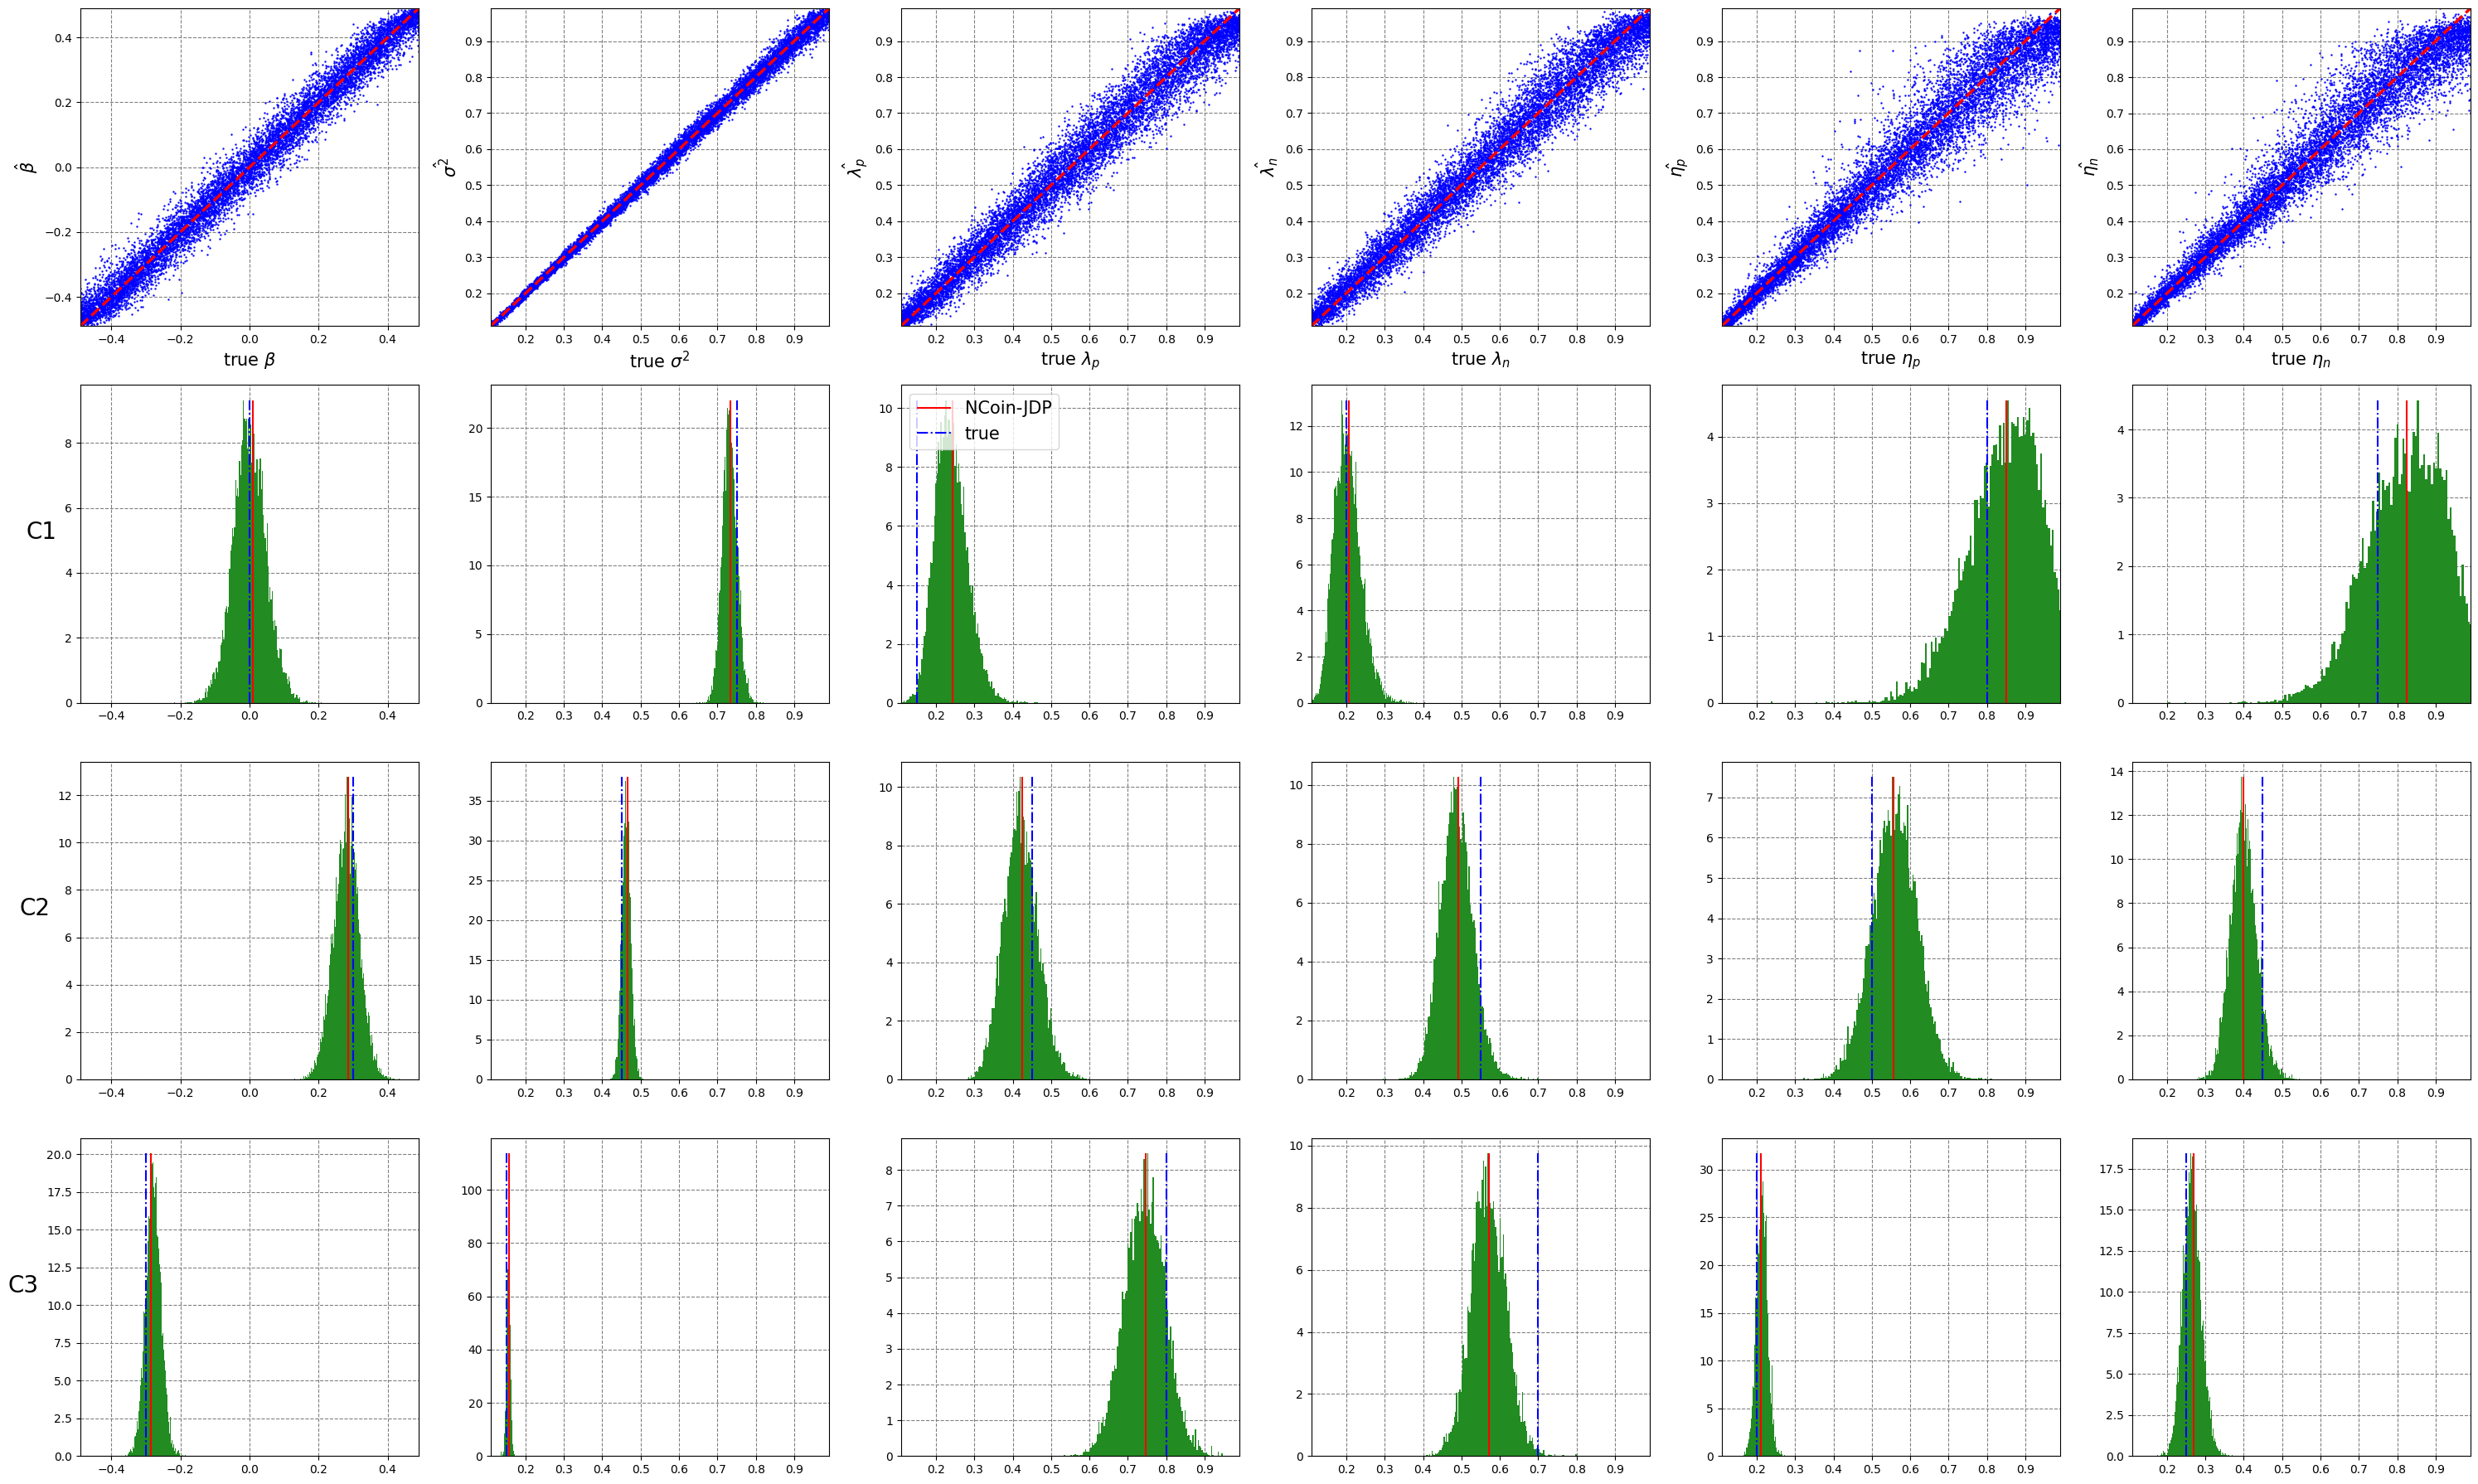

In [22]:
import matplotlib.pyplot as plt
true_name = [r'true $\beta$', r'true $\sigma^2$', r'true $\lambda_p$', 
             r'true $\lambda_n$', r'true $\eta_p$', r'true $\eta_n$']
#true_name = [r'true $\kappa$', r'true $\beta$', r'true $\lambda$', r'true $\mu$']

true_param = np.array(torch.stack([param,param1,param2]))

fig, axs = plt.subplots(4, len(true_name), figsize=(30,18))

est = [net(x0).detach()[0], net(x1).detach()[0], net(x2).detach()[0]]


with torch.no_grad():
    net.eval()
    tmp = net(X_test)
    tmp = tmp.detach().cpu().numpy()

## Plot for model checking

lim_left = torch.quantile(output,.01, 0).detach().cpu().numpy()
lim_right = torch.quantile(output,.99, 0).detach().cpu().numpy()


for i in range(len(tmp[0])):
    lim0 = lim_left[i]
    lim1 = lim_right[i]
    tmp1 = tmp[:, i]
    axs[0,i].scatter(y_test[:,i], tmp1, marker='o', color='b', s= 0.5)
    axs[0,i].set_xlabel(true_name[i], fontsize=15)
    axs[0,i].set_ylabel(esti_name[i], fontsize=15)
    axs[0,i].plot(np.linspace(lim0, lim1, 1000), np.linspace(lim0, lim1, 1000), color = "red", linestyle='dashed', linewidth = 2.5)
    axs[0,i].set_axisbelow(True)
    axs[0,i].grid(color='gray', linestyle='dashed')
    axs[0,i].set_ylim([lim0, lim1])
    axs[0,i].set_xlim([lim0, lim1])
    #axs[0,0].set_title("Learning Checking", fontsize = 10)

for j in range(3):
    samples_plot = samples[j]
    samples_plot = np.array(samples[j])
    samples_plot = np.concatenate(samples_plot, axis = 1)

    for i in range(len(true_name)):
        lim0 = lim_left[i]
        lim1 = lim_right[i]
        
        y, x, _ = axs[j+1,i].hist(samples_plot[i,:], density=True, bins = 150, color = "forestgreen")
        axs[j+1,i].set_axisbelow(True)
        axs[j+1,i].grid(color='gray', linestyle='dashed')
        axs[j+1,i].set_xlim([lim0, lim1])
    
        axs[j+1,i].vlines(est[j][i], 0, max(y), color = 'red')
        axs[j+1,i].vlines(true_param[j,i], 0, max(y), color = 'blue', linestyle ="dashdot")
        if i == 2 and j == 1:
            axs[j,i].legend(['NCoin-JDP', 'true'], loc = "upper left", fontsize=15) 
axs[1, 0].set_ylabel("C1", fontsize=20, rotation=0, labelpad=20)
axs[2, 0].set_ylabel("C2", fontsize=20, rotation=0, labelpad=20)
axs[3, 0].set_ylabel("C3", fontsize=20, rotation=0, labelpad=20)
fig.tight_layout()
fig.savefig("../JD_plots/PBJD_infer.pdf") 

In [20]:
# Mean
# Mode
# MAD
# STD
# 95% credible intervals

post_mean = []
post_med = []
post_mode = []
post_mad = []
post_std = []
post_interval = []
for i in range(3): #3 cases
    samples_plot = samples[i]
    samples_plot = np.array(samples[i])
    samples_plot = np.concatenate(samples_plot, axis = 1)

    post_mean_1 = []
    post_med_1 = []
    post_mode_1 = []
    post_mad_1 = []
    post_std_1 = []
    post_interval_1 = []
    
    for j in range(len(true_name)):
        tmp = samples_plot[j,:]
        np.random.seed(1)
        hpd_source = hpd_grid(tmp, 0.1, 5)
        
        post_mean_1.append(np.mean(tmp)) # mean
        post_med_1.append(np.median(tmp)) # mean
        post_mode_1.append(hpd_source[3][0]) # mode
        post_mad_1.append(mad_np(tmp)) # mad
        post_std_1.append(np.std(tmp))
        post_interval_1.append(np.array(hpd_source[0][0])) # interval
    
    post_mean.append(post_mean_1)
    post_med.append(post_med_1)
    post_mode.append(post_mode_1)
    post_mad.append(post_mad_1)
    post_std.append(post_std_1)
    post_interval.append(post_interval_1)

/tmp/ipykernel_19185/1091780546.py:30: DeprecationWarning: Please use `gaussian_kde` from the `scipy.stats` namespace, the `scipy.stats.kde` namespace is deprecated.
  density = kde.gaussian_kde(sample)


In [21]:
for i in range(3):
    print("Posterior mean C" + str(i), np.round(post_mean[i], 3))
    print("Posterior median C" + str(i), np.round(post_med[i], 3))
    print("Posterior mode C" + str(i), np.round(post_mode[i],3))
    print("Posterior mad  C" + str(i), np.round(post_mad[i],3))
    print("Posterior std  C" + str(i), np.round(post_std[i],3))
    print("Posterior intvl C" + str(i), np.round(post_interval[i],3))
    print("===========================================================================")


Posterior mean C0 [0.    0.732 0.24  0.204 0.84  0.819]
Posterior median C0 [-0.001  0.732  0.237  0.201  0.851  0.826]
Posterior mode C0 [-0.013  0.732  0.226  0.19   0.905  0.851]
Posterior mad  C0 [0.032 0.013 0.029 0.023 0.066 0.072]
Posterior std  C0 [0.048 0.019 0.042 0.035 0.092 0.098]
Posterior intvl C0 [[-0.079  0.078]
 [ 0.701  0.764]
 [ 0.172  0.308]
 [ 0.147  0.26 ]
 [ 0.708  0.99 ]
 [ 0.673  0.98 ]]
Posterior mean C1 [0.281 0.463 0.421 0.488 0.56  0.4  ]
Posterior median C1 [0.281 0.462 0.42  0.486 0.56  0.399]
Posterior mode C1 [0.28  0.461 0.416 0.482 0.569 0.395]
Posterior mad  C1 [0.025 0.008 0.03  0.028 0.039 0.023]
Posterior std  C1 [0.038 0.012 0.045 0.043 0.059 0.034]
Posterior intvl C1 [[0.217 0.343]
 [0.443 0.482]
 [0.346 0.495]
 [0.417 0.557]
 [0.461 0.657]
 [0.343 0.456]]
Posterior mean C2 [-0.278  0.156  0.744  0.57   0.214  0.266]
Posterior median C2 [-0.278  0.156  0.744  0.569  0.214  0.265]
Posterior mode C2 [-0.279  0.156  0.745  0.566  0.217  0.261]
Post